## Inicjalizacja środowiska programistycznego

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math, string, glob
from datetime import datetime
import numpy as np
import functools

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow  as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params) 

import os
os.chdir("/scratch_hdd/akalinow/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/PL/")

#append path with python modules
import importlib
import sys
sys.path.append("../modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

import text_functions as txt_fcn
importlib.reload(txt_fcn);
#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

Istnieje, niekompletny, zbiór standardowych operacji jakie wykonujemy na różnego typu danych zanim zostaną użyte jako wejście do modelu.
API Keras dostarcza gotowych warstw wykonujących wiele z tych [operacji](https://www.tensorflow.org/guide/keras/preprocessing_layers).
W tym notatniku użyjemy kilku z nich dla różnych rodzajów danych: **numerycznych**, **tekstowych**, **obrazów**.

## Dane numeryczne

### Normalizacja

Standardowa operacja, jaką wykonujemy na danych numerycznych przez podaniem ich na wejście modelu to normalizacja.
Normalizacja powoduje że rząd wielkości wag jest podobny dla wszystkich cech, a same wagi nei są zbyt duże.

```Python

normalization = tf.keras.layers.Normalization(mean, variance) # Normalizacja danych do średniej mean i wariancji wariance
                                                               # domyślnie mean=0, variance=1
                                                               # normalizacja przebiega dla każdej cechy oddzielnie
                                                               # wymaga ustalenia współczynników normalizacji przez metodę adapt(x)
normalization.adapt(x)                                                             
```


**Proszę:**

* wygenerować zbiór `(n,4)` liczb pochodzących z rozkładu płaskiego w zakresach `[[-5,5],[-4,2],[2,2]]`
* wypisać na ekran wartości minimalne, maksymalne  i średnią cech w zbiorze
* znormalizować dane do zakresu `[0,1]` dla każdej cechy oddzielnie
* wypisać na ekran wartości minimalne, maksymalne  i średnią cech w znormalizowanym zbiorze
* sprawdzić czy normalizacja zadziałała zgodnie z oczekiwaniem

In [35]:
n = 10_00
#BEGIN_SOLUTION
x = tf.random.uniform([n, 3])
scales = np.array([[-5,5],[-4,2],[-2,2]])
ranges = scales[:,1] - scales[:,0]
x = x * ranges + scales[:,0]
print(colored("min =", "blue"), tf.math.reduce_min(x, axis=0).numpy())
print(colored("mean =", "blue"), tf.math.reduce_mean(x, axis=0).numpy())
print(colored("max =", "blue"), tf.math.reduce_max(x, axis=0).numpy())
print(colored("stddev =", "blue"), tf.math.reduce_std(x, axis=0).numpy())
normalization = tf.keras.layers.Normalization()
normalization.adapt(x)
x = normalization(x)
print(colored("min =", "blue"), tf.math.reduce_min(x, axis=0).numpy())
print(colored("mean =", "blue"), tf.math.reduce_mean(x, axis=0).numpy())
print(colored("max =", "blue"), tf.math.reduce_max(x, axis=0).numpy())
#END_SOLUTION
pass

min = [-4.998664  -3.9879587 -1.9989281]
mean = [ 0.01361813 -0.9183178   0.02975328]
max = [4.9674206 1.9995165 1.9958544]
stddev = [2.7890291 1.6713271 1.1465598]
min = [-1.7971421 -1.8366487 -1.7693636]
mean = [-3.8146974e-09 -1.8596650e-08 -2.2888184e-08]
max = [1.7761745 1.7458187 1.7147827]



### Dyskretyzacja 

Czasami użyteczny jest podział danych numerycznych na kategorie - **dyskretyzacja**.
W sytuacji, gdy nie potrzebujemy dużej rozdzielczości wartości zmiennoprzecinkowe możemy podzielić 
np. na `małe`, `średnie` i `duże`.
Redukcja rozdzielczości z poziomu zmiennoprzecinkowego do listy kategorii może też ułatwić trening.

```Python

discretization = tf.keras.layers.Discretization(num_bins, bin_boundaries, output_mode) 
                 # Zamiana zmiennej ciągłej na dyskretną w postaci:
                 # output_mode = int - numer przedziału (wartość domyślna)
                 #               one_hot - wektor typu kodowania gorącojedynkowego
                 # num_bins - liczba przedziałów (wymaga zawołania metody adapt(x))
                 # bin_boundaries - zakresy przedziałów
```

**Proszę:**

* zdyskretyzować dane z poprzedniej komórki do 10 przedziałów
* narysować histogram numerów przedziałów dla **wszystkich** cech

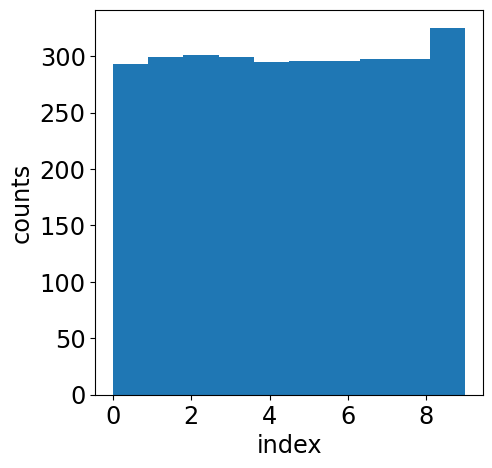

In [36]:
#BEGIN_SOLUTION
discretization = tf.keras.layers.Discretization(num_bins=10)
discretization.adapt(x)
y = discretization(x)

fig, axis = plt.subplots(1,1, figsize=(5,5))
counts, bins, _ = axis.hist(tf.reshape(shape=(-1,), tensor=y))
axis.set_xlabel('index')
axis.set_ylabel('counts')
#END_SOLUTION
pass

## Obrazy

**Proszę:**

* korzystając z biblioteki `tensorflow_datasets` załadować zbiór `imagenette/160px`
* narysować kilka przykładowych rysunków

2024-05-28 15:09:26.604556: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-28 15:09:26.611656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


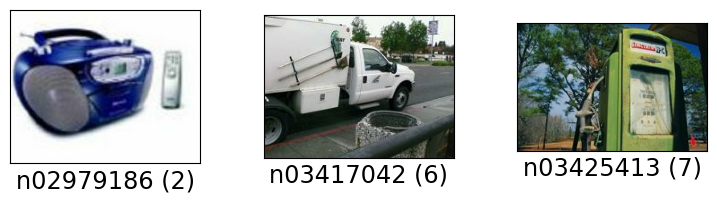

In [38]:
#BEGIN_SOLUTION
ds, ds_info = tfds.load('imagenette/160px', split='train', with_info=True)
fig = tfds.show_examples(ds, ds_info, rows=1, cols=3);
#END_SOLUTION
pass


### Skalowanie

Zmiana rozdzielczości - skalowanie obrazu. Skalowanie wymaga podania algorytmu interpolacji, pozwalającego
na obliczenie wartości pikseli w nowym obrazie.

```Python
tf.keras.layers.Resizing(
    height, width,                # szerokość i wysokość nowego obrazu
    interpolation='bilinear',     # algorytm interpolacji
    crop_to_aspect_ratio=False,   # przycinanie obrazu w celu uzyskania
                                  # tego samego stosunku szerokość/długość
                                  # jak w obrazie oryginalnym
)
```


## Przycinane

z całego obrazu jest wycinany fragment, `ramka`:


```Python
tf.keras.layers.CenterCrop(
    height, width              # szerokość i wysokość prostokąta wycinającego 
                               # fragment w środku obrazu
)
```

Przycinanie w losowym miejscu może być użyte do wzbogacania próbki, poprzez generację
losowych fragmentów obrazu - ang. `augmenting`. Warstwy wykonujące losowe operacje na obrazach
są domyślnie aktywne tylko w czasie treningu.

```Python
tf.keras.layers.RandomCrop(
    height, width, seed=None,  # szerokość i wysokość prostokąta wycinającego 
                               # fragment w losowym miejscu
                               #
)
```



### Obrót

```Python
tf.keras.layers.RandomRotation(
    factor,                         # zakres obrotu w jednostkach 2pi: (min, max)
    fill_mode='reflect',            # algorytm wypełnienia przestrzeni powstałej po obrocie obrazu
    interpolation='bilinear',
    seed=None,
    fill_value=0.0,                 # wartość piksela użytego do wypełniania przestrzeni powstałej po przesunięciu obrazu,
                                    # jeśli jako `fill_mode=constant`
)
```




### Translacja

```Python
tf.keras.layers.RandomTranslation(
    height_factor,                  # względny współczynnik przesunięcia w pionie: (min, max)
    width_factor,                   # względny współczynnik przesunięcia w poziomie: (min, max)
    fill_mode='reflect',            # algorytm wypełnienia przestrzeni powstałej po przesunięciu obrazu
    interpolation='bilinear',
    seed=None,
    fill_value=0.0,                 # wartość piksela użytego do wypełniania przestrzeni powstałej po przesunięciu obrazu,
                                    # jeśli jako `fill_mode=constant`
)
```


**Proszę:**

Narysować losowe obrazy ze zbioru `imagenette/160px` poddane:
* skalowaniu obszaru do rozdzielczości `(320,320)`
* wypisać na ekran rozdzielczość pierwszego przykładu

**Wskazówki:**
* należy użyć metody `tf.data.Dataset.map()` z odpowiednią funkcją mapowania opartą o odpowiednią warstwę
* uwaga na typ danych w tensorze zawierającym przetworzone obrazy

2024-05-28 15:09:33.045287: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-28 15:09:33.050994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


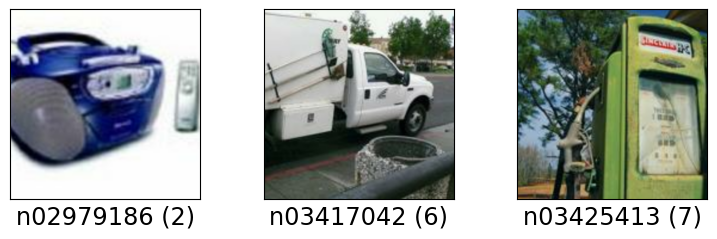

Resolution:  320 320


2024-05-28 15:09:33.173999: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [39]:
#BEGIN_SOLUTION
ds = ds.map(lambda x: {"image": tf.keras.layers.Resizing(320,320, crop_to_aspect_ratio=True, dtype=tf.uint8)(x["image"]), "label": x["label"]})
tfds.show_examples(ds, ds_info, rows=1, cols=3)
item = next(iter(ds))
x_res = item["image"].shape[0]
y_res = item["image"].shape[1]
print(colored("Resolution: ", "blue"), x_res, y_res)          
#END_SOLUTION
pass

**Proszę:**

Narysować losowe obrazy ze zbioru `imagenette/160px` poddane:
* przycinaniu do obszaru centralnego o rozmiarze `(64,64)`

**Wskazówki:**
* należy użyć metody `tf.data.Dataset.map()` z odpowiednią funkcją mapowania opartą o `tf.keras.layers.CenterCrop`
* uwaga na typ danych w tensorze zawierającym przetworzone obrazy

2024-05-28 15:09:35.382502: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-28 15:09:35.387673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


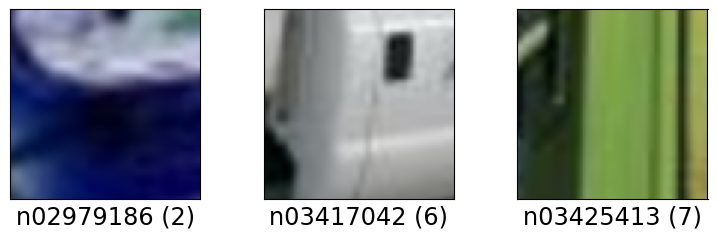

In [40]:
#BEGIN_SOLUTION
layer = tf.keras.layers.CenterCrop(64,64, dtype=tf.uint8)
ds_randomCrop = ds.map(lambda x: {"image": layer(x["image"]), "label": x["label"]})
tfds.show_examples(ds_randomCrop, ds_info, rows=1, cols=3);
#END_SOLUTION
pass

**Proszę:**

Narysować losowe obrazy ze zbioru `imagenette/160px` poddane:

* losowemu przycinaniu do obszaru o rozmiarze `(64,64)`

**Wskazówki:**
* użycie warstwy w definicji funkcji lambda spowoduje błędy. Proszę spróbować zinterpretować komunikat o błędzie i odpowiednio skorygować kod.


2024-05-28 15:09:37.847775: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-28 15:09:37.853858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


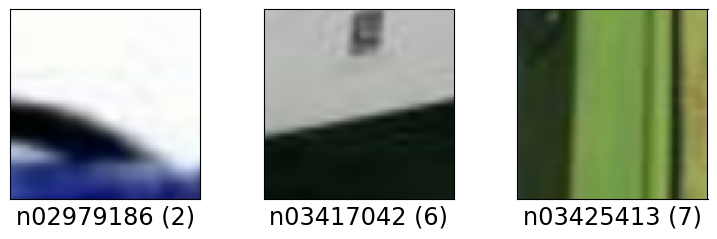

In [41]:
#BEGIN_SOLUTION
layer = tf.keras.layers.RandomCrop(64,64, dtype=tf.uint8)
ds_randomCrop = ds.map(lambda x: {"image": layer(x["image"]), "label": x["label"]})
tfds.show_examples(ds_randomCrop, ds_info, rows=1, cols=3);
#END_SOLUTION
pass

**Proszę:**

Narysować losowe obrazy ze zbioru `imagenette/160px` poddane:

* losowemu obrotowi w zakresie $\pm \pi/4$
* puste miejsca po obrocie proszę wypełnić kolorem czarnym

**Wskazówki:**
* użycie warstwy w definicji funkcji lambda spowoduje błędy. Proszę spróbować zinterpretować komunikat o błędzie i odpowiednio skorygować kod.


2024-05-28 15:09:39.983043: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-28 15:09:39.989428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


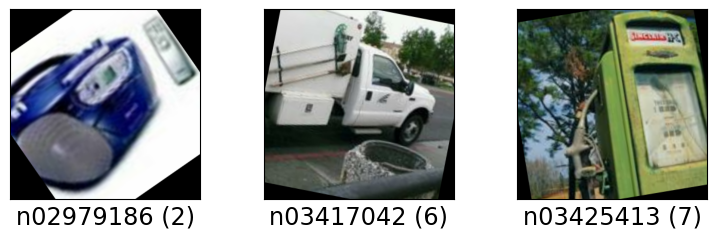

In [42]:
#BEGIN_SOLUTION
layer = tf.keras.layers.RandomRotation(1/8.0, fill_mode='constant',  dtype=tf.uint8)
ds_randomRotation = ds.map(lambda x: {"image": layer(x["image"]), "label": x["label"]})
tfds.show_examples(ds_randomRotation, ds_info, rows=1, cols=3);
#END_SOLUTION
pass

## Dane tekstowe

Zamiana tekstu na postać cyfrową może być wykonana na wiele sposobów. Dwa najbardziej popularne to:
* **wektoryzacja (ang. text vectorization)** - każdemu znacznikowi (ang. `token`) jest przypisana liczba całkowita, indeks w słowniku. 
                 Odwzorowanie   ${\mathrm tekst}  \leftrightarrow {\mathrm indeks}$ jest ustalane na podstawie zawartości zbioru danych. 

* **zanurzanie (ang. embedding)** - każdemu znacznikowi jest przypisany n-wymiarowy wektor liczb zmiennoprzecinkowych.
    Odwzorowanie   ${\mathrm tekst}  \leftrightarrow {\mathrm indeks}$ jest znajdowanie w czasie treningu modelu.

### Wektoryzacja

```Python
tf.keras.layers.TextVectorization(
    max_tokens=None,                           # maksymalna liczba znaczników w słowniku
    standardize='lower_and_strip_punctuation', # algorytm standaryzacji tekstu
    split='whitespace',                        # algorytm podziału na słowa
    ngrams=None,                               # algorytm podziału słów na n-literowe fragmenty 
    output_mode='int',                         # typ wyjścia   
    output_sequence_length=None,               # maksymalna długość zakodowanej sekwencji "zdania" 
    pad_to_max_tokens=False,                   # czy dopełniać sekwencję zerami do maksymalnej długości
    vocabulary=None                            # słownik. Jeśli nie jest podany generacja słownika wymaga zawołania
                                               # metody adapt()
)
 ```

 Znaczniki nie występujące w słowniku otrzymają ten sam indeks oznaczający znacznik OOV (`ang. out of vocabulary`) 

**Proszę:**

* zbudować słownik na tekście `wksf/Korpus_surowy` wczytywanym w ramach zadania domowego z poprzedniego notatnika
* zwektoryzować teskt `Król zasiada na tronie.`
* wypisać na ekran zwektoryzowaną postać
* przeprowadzić operację odwrotną - z postaci zwektoryzowanej odtworzyć tekst
* powtórzyć procedurę dla tekstu `Ania ma małego kotka.`

**Wskazówki**: 
* słownik utworzony przez warstwę `tf.keras.layers.TextVectorization` uzyskujemy przez metodę `get_vocabulary()`
* z elementów sekwencji `words` można utworzyć napis w następujący sposób:
```Python
sentence = " ".join(words)
```


In [49]:
import text_functions as txt_fcn

filePath = "../data/wksf/Korpus_surowy/"
dataset = txt_fcn.load_wksf_dataset(filePath)

#BEGIN_SOLUTION
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=1000000, output_mode = "int")
vectorize_layer.adapt(dataset.batch(128))

text = 'Król zasiada na tronie.'
#text = 'Królowa zasiada na tronie.'
#text = 'Ania ma małego kotka.'
print(colored("Text:", "blue"), text)
encoded = vectorize_layer(tf.constant(text))
print(colored("Encoded:", "blue"), encoded.numpy())

vocabulary = vectorize_layer.get_vocabulary()
vocab_arr = np.array(vocabulary) 
decoded = " ".join(vocab_arr[encoded.numpy()])
print(colored("Decoded: ", "blue"), decoded)
#END_SOLUTION
pass


Reading text from files: ['../data/wksf/Korpus_surowy/a-publi.txt', '../data/wksf/Korpus_surowy/b-prasa.txt', '../data/wksf/Korpus_surowy/d-proza.txt', '../data/wksf/Korpus_surowy/e-dramat.txt', '../data/wksf/Korpus_surowy/c-popul.txt']


2024-05-28 15:18:11.734707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Text: Król zasiada na tronie.
Encoded: [ 1405 39530     6 25451]
Decoded:  król zasiada na tronie


### Zanurzanie


```Python
tf.keras.layers.Embedding(
    input_dim,                          # rozmiar słownika - liczba znaczników ("tokenów")
    output_dim,                         # wymiar reprezentacji  
)
```

Warstwa zanurzająca przypisuje wartość zmiennoprzecinkową każdemu znacznikowi.
Taką operację można reprezentować przez macierz `(output_dim, input_dim)` która działa na wektor gorącojedynkowy o długości `(input_dim)`
i produkuje reprezentację zmiennoprzecinkową o długości `output_dim`
Tutaj `output_dim=3`:

$$
\huge{
\begin{bmatrix}
a_{0} & b_{0} & c_{0} & \dots \\
a_{1} & b_{1} & c_{1} & \dots \\
a_{2} & b_{2} & c_{2} & \dots \\
\end{bmatrix}
\cdot
\begin{bmatrix}
1 \\
0 \\
0 \\
\dots \\
0
\end{bmatrix}
=
\begin{bmatrix}
a_{0} \\
a_{1} \\
a_{2} 
\end{bmatrix}
}
$$
Warstwa `tf.keras.layers.Enbedding()` realizuje tę operację w sposób zoptymalizowany.
Macierz zanurzania jest zwykle zmieniana w trakcie treningu modelu który ją zawiera, więc nie jest to standardowa warstwa wstępnego przetwarzania.


**Proszę:**

* zwektoryzować teskt `Król zasiada na tronie.`
* zwektoryzowaną postać podać na wejście warstwy zanurzającej z `nDims = 4`
* wypisać na ekran obie postacie tekstu

In [48]:
#BEGIN_SOLUTION
nTokens = len(vocabulary)
nDims = 4 
embedding_layer = tf.keras.layers.Embedding(nTokens, nDims)

text = 'Król zasiada na tronie.'
#text = 'Królowa zasiada na tronie.'
encoded = vectorize_layer(tf.constant(text))
print(colored("Encoded:", "blue"), encoded.numpy())
print(colored("Embedded: ", "blue"), embedding_layer(encoded).numpy())
#END_SOLUTION
pass

Encoded: [ 1405 39530     6 25451]
Embedded:  [[-0.00581223  0.01069899 -0.03654243 -0.04711893]
 [ 0.00436519  0.02839713 -0.0247662  -0.01974664]
 [ 0.00269129  0.00054507  0.02605632  0.01319465]
 [ 0.04364446 -0.01070942 -0.01794361  0.03239942]]


### Podział na n-gramy

W czasie analizy tekst zwykle dzieli się na fragmenty zawierające `n` znaczników (ang. `tokens`) - n-gramy.
Podzielimy zdania wczytane z korpusu języka polskiego na odcinki o długości `n` wyrazów. Skorzystamy z gotowych funkcji służących 
do operowania na napisach dostępnych w dedykowanej bibliotece `tensorflow_text`

* podział tekstu na fragmenty (tutaj wyrazy oddzielone spacją):
```Python
tensorflow_text.WhitespaceTokenizer().tokenize(text)
```

* tworzenie grup o wybranej długości z użyciem biegnącego okna - grupy się przekrywają za wyjątkiem ostatniego wyrazu, czyli krok okna ang. `stride`
wynosi 1
```Python
tensorflow_text.tf_text.sliding_window(data,       # lista znaczników        
                                       width,      # szerokość okna przebiegającego listę
                                       axis=-1,    # wymiar, wzdłuż którego biegnie okno
                                       name=None   # nazwa funkcji
```

In [55]:
import tensorflow_text as tf_text
import functools

# load the dataset
filePath = "../data/wksf/Korpus_surowy/"
dataset = txt_fcn.load_wksf_dataset(filePath)

# split lines into words
dataset = dataset.map(tf_text.WhitespaceTokenizer().tokenize)

# remove empty lines 
dataset = dataset.filter(lambda x: tf.size(x) > 0)

# fix all function arguments except for the input data
window_size = 5
slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size)

# apply the sliding window to each line.
# this will priduce a tensor of shape (n, width) for each line,
# where n in the number of groups of words of words of width length
dataset = dataset.map(slidingWindowWithWidth)

print(colored("First example:", "blue"))
for item in dataset.take(1):
    print(colored("Text: ", "blue"), item.numpy())

Reading text from files: ['../data/wksf/Korpus_surowy/a-publi.txt', '../data/wksf/Korpus_surowy/b-prasa.txt', '../data/wksf/Korpus_surowy/d-proza.txt', '../data/wksf/Korpus_surowy/e-dramat.txt', '../data/wksf/Korpus_surowy/c-popul.txt']
First example:
Text:  [[b'Sztuka' b'utraci\xc5\x82a' b'swoj\xc4\x85' b'moc'
  b'pobudzaj\xc4\x85c\xc4\x85:']
 [b'utraci\xc5\x82a' b'swoj\xc4\x85' b'moc' b'pobudzaj\xc4\x85c\xc4\x85:'
  b'przykrym']
 [b'swoj\xc4\x85' b'moc' b'pobudzaj\xc4\x85c\xc4\x85:' b'przykrym'
  b'widowiskiem']
 [b'moc' b'pobudzaj\xc4\x85c\xc4\x85:' b'przykrym' b'widowiskiem'
  b'staje']
 [b'pobudzaj\xc4\x85c\xc4\x85:' b'przykrym' b'widowiskiem' b'staje'
  b'si\xc4\x99']
 [b'przykrym' b'widowiskiem' b'staje' b'si\xc4\x99' b'koncert']
 [b'widowiskiem' b'staje' b'si\xc4\x99' b'koncert' b'wybitnej']
 [b'staje' b'si\xc4\x99' b'koncert' b'wybitnej' b'niegdy\xc5\x9b']
 [b'si\xc4\x99' b'koncert' b'wybitnej' b'niegdy\xc5\x9b'
  b'\xc5\x9bpiewaczki']
 [b'koncert' b'wybitnej' b'niegdy\xc5\x9b

2024-05-28 15:19:46.367926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Po podziale na n-gramy z jednego wiersza zrobiło się wiele fragmentów o długości `window_size`. Możemy je traktować jako paczki.
Operacja rozpaczkowania, `dataset.unbatch()` z powrotem przywróci zbiór do `postaci jeden przykład na wiersz`.

Rozpaczkowane wyrazy możemy z powrotem połączyć w fragmenty zdań.


In [56]:
# split the (n, width) tensor into (n) tensors of shape (width)
dataset = dataset.unbatch()

# merge words into sentence framgents
dataset = dataset.map(lambda x: tf.strings.reduce_join(x, separator=' '))

print(colored("First five five-word blocks:", "blue"))
for item in dataset.take(5):
    print(colored("Text: ", "blue"), item.numpy().decode())

First five five-word blocks:
Text:  Sztuka utraciła swoją moc pobudzającą:
Text:  utraciła swoją moc pobudzającą: przykrym
Text:  swoją moc pobudzającą: przykrym widowiskiem
Text:  moc pobudzającą: przykrym widowiskiem staje
Text:  pobudzającą: przykrym widowiskiem staje się


2024-05-28 15:23:37.622865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Proszę:**

* stworzyć słownik do wektoryzacji tekstu używając warstwy `tf.keras.layers.TextVectorization.adapt(...)`
* stworzyć zwektoryzowany zbiór danych: `dataset_vectorized` używając warstwy `tf.keras.layers.TextVectorization` i operacji `dataset.map()`
* zachować słownik w zmiennej `vocabulary` w postaci macierzy numpy
* usunąć przykłady z miej niż dwo wyrazami w zdaniu
* wypisać na ekran liczbę znaczników w słowniku
* wypisać na ekran pięć pierwszych przykładów w zwektoryzowanej postaci

**Wskazówka:**
* operacje na zbiorach danych można przyspieszyć wykonując je na paczkach:
```Python
dataset.batch(n).map(...).unbatch()
``` 

In [57]:
#BEGIN_SOLUTION
vectorize_layer = tf.keras.layers.TextVectorization(output_mode = "int")
vectorize_layer.adapt(dataset.batch(1024))
vocabulary = np.array(vectorize_layer.get_vocabulary())
vocabulary_length = vocabulary.shape[0] 
dataset_vectorized = dataset.batch(1024).map(vectorize_layer, num_parallel_calls=tf.data.AUTOTUNE).unbatch()
dataset_vectorized = dataset_vectorized.filter(lambda x: tf.math.count_nonzero(x==1, axis=0) < 2)
print(colored("Vocabulary length: ", "blue"), vocabulary_length)
#END_SOLUTION

print(colored("First five five-word blocks in the vectorized form:", "blue"))
for item in dataset_vectorized.take(5):
    print(colored("Text: ", "blue"), item)

2024-05-28 15:24:56.004797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Vocabulary length:  84808
First five five-word blocks in the vectorized form:
Text:  tf.Tensor([ 2539 15341   382  2092 56993], shape=(5,), dtype=int64)
Text:  tf.Tensor([15341   382  2092 56993 25962], shape=(5,), dtype=int64)
Text:  tf.Tensor([  382  2092 56993 25962 16798], shape=(5,), dtype=int64)
Text:  tf.Tensor([ 2092 56993 25962 16798   832], shape=(5,), dtype=int64)
Text:  tf.Tensor([56993 25962 16798   832     4], shape=(5,), dtype=int64)


2024-05-28 15:24:56.373729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Proszę:**

* przekształcić zwektoryzowany zbiór zawierający n-gramy do postaci `(cechy, etykieta)` gdzie:
    * **etykieta** - środkowy wyraz
    * **cechy** - wyrazy poza wyrazem środkowym

* przekształcenie powinno korzystać z metody `Dataset.map(...)` z użyciem własnej funkcji mapującej `map_fn(...)`
* założyć, że zbiór został podzielony na paczki, więc pojedynczy element ma kształt `(None,width)`
* wypisać na ekran cechy i etykiety dla pięciu przykładów

**Wskazówki**: 
* można założyć że `n=5`
* można założyć, że środkowy wyraz ma indeks `2`


In [58]:
###################################################
def map_fn(x):
    #BEGIN_SOLUTION
    middle = 2
    features =  tf.concat((x[:,:middle], x[:,middle+1:]), axis=1)
    label = x[:,middle]
    #END_SOLUTION
    return features, label
###################################################
def print_item(batch, vocabulary, width=2):
    batch_index = 0
    item = (batch[0][batch_index], batch[1][batch_index])
    features = " ".join(vocabulary[item[0].numpy()[0:width]])
    label = vocabulary[item[1].numpy()]   
    print(colored("Features", "blue"), end=" ")
    print(colored("(Label):", "red"), end=" ")

    print(features, end=" ")
    print(colored(label,"red"), end=" ")
    features = " ".join(vocabulary[item[0].numpy()[width:]])
    print(features)
################################################### 

dataset_final = dataset_vectorized.batch(32).map(map_fn)

for item in dataset_final.take(5):
    print_item(item, vocabulary)
    print(colored("Vectorized form:", "blue"), )
    print(colored("Features: ", "blue"), item[0][0].numpy(), end=" ")
    print(colored("Label: ", "blue"), item[1][0].numpy())  

Features (Label): sztuka utraciła swoją moc pobudzającą
Vectorized form:
Features:  [ 2539 15341  2092 56993] Label:  382
Features (Label): czym innym i śpiewaczka postarzawszy
Vectorized form:
Features:  [  169   661 36093 55391] Label:  3
Features (Label): zaś rewanżuje się pogardą i
Vectorized form:
Features:  [  243 51379 18045     3] Label:  4
Features (Label): eksport drewna najwyższych gatunków i
Vectorized form:
Features:  [3194 3123 4044    3] Label:  3768
Features (Label): jako kolekcji nazwisk albo prądów
Vectorized form:
Features:  [   88 19024   142 15840] Label:  6577


2024-05-28 15:32:32.441452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Proszę:**

* sprawdzić prędkość czytania finalnego zbioru danych korzystając z funkcji `benchmark`


In [59]:
#BEGIN_SOLUTION
tfds.benchmark(dataset_final)
#END_SOLUTION
pass


************ Summary ************



0it [00:00, ?it/s]

Examples/sec (First included) 2676.62 ex/sec (total: 15781 ex, 5.90 sec)
Examples/sec (First only) 7.05 ex/sec (total: 1 ex, 0.14 sec)
Examples/sec (First excluded) 2742.44 ex/sec (total: 15780 ex, 5.75 sec)


2024-05-28 15:32:42.915786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Zadanie domowe

**Proszę:**

* załadować tekst z pliku filePath = `shakespeare.txt'`

```Python

filePath = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
```

* wykonać `preprocessing` tekstu:
    * podział tekstu na fragmenty o długości pięciu wyrazów. Jeden przykład w nowym zbiorze powinien składać się jednego 5-wyrazowego fragmentu, 
      a nie grupy fragmentów powstałej z podziału zdania na kawałki o długości pięciu wyrazów:
      ```
      
      Features (Label): before we proceed any further
      Features:  [128  33 123 639] Label:  1267
      ```
    * tokenizacja ze słownikiem ograniczonym do **1000** znaczników
    * podział fragmentów na etykietę (wyraz środkowy) i cechy (pozostałe wyrazy)
      

* wypisać na ekran pięć przykładów z zaznaczeniem cech i etykiety
* stworzyć warstwę zanurzającą ze `128` wymiarami
* wypisać na ekran pięć wyrazów najbliższych wyrazowi `man` w przestrzeni zanurzającej z odległością kosinusową:
```Python
cosine_similarity = tf.keras.losses.cosine_similarity(...)
```
* wypisać na ekran pięć słów najbliższych do sumy słów `mother` i `father` wykonanej w przestrzeni zanurzenia

**Wskazówki:**
* największe `n` wartości z listy można uzyskać funkcją `tf.math.top_k(...)`

<hr>

**Opcjonalnie:**

* przeprowadzić trening warstwy zanurzającej ze `128` wymiarami z użyciem algorytmu ciągłego worka słów - [`Continous Bag of Words (CBOW)`](https://d2l.ai/chapter_natural-language-processing-pretraining/word2vec.html#the-continuous-bag-of-words-cbow-model) (wersja naiwna).

**Wskazówki:**

* obliczenie iloczynu skalarnego reprezentacji cech i wszystkich słów słownika wymaga zdefiniowania warstwy liczącej iloczyn skalarny:
```Python
class Dot(tf.keras.Layer):
    def call(self, x):
        dot_product = ...
        return dot_product

```
i użycia jej w definicji modelu.
<hr>

In [15]:

# load text
#BEGIN_SOLUTION
filePath = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
dataset = txt_fcn.load_wksf_dataset(filePath)
#END_SOLUTION

# adapt vextorization layer
#BEGIN_SOLUTION
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=1000, output_mode = "int")
vectorize_layer.adapt(dataset.batch(128))
#END_SOLUTION

# split lines into words
#BEGIN_SOLUTION
dataset = dataset.map(tf_text.WhitespaceTokenizer().tokenize)
#END_SOLUTION

# fix all tf_text.sliding_window function arguments except for the input data
#BEGIN_SOLUTION
window_size = 5
slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size)
#END_SOLUTION

# apply the sliding window to each line.
# this will produce a tensor of shape (n, width) for each line,
# where n in the number of groups of words with length width
#BEGIN_SOLUTION
dataset = dataset.map(slidingWindowWithWidth)
#END_SOLUTION

# remove empty lines 
#BEGIN_SOLUTION
dataset = dataset.filter(lambda x: tf.size(x) > 0)
#END_SOLUTION

# split the (n, width) tensor into (n) tensors of shape (width)
#BEGIN_SOLUTION
dataset = dataset.unbatch()
#END_SOLUTION

# merge words into sentence framgents
#BEGIN_SOLUTION
dataset = dataset.map(lambda x: tf.strings.reduce_join(x, separator=' '))
#END_SOLUTION

#Vectorize
#BEGIN_SOLUTION
vectorize_layer = tf.keras.layers.TextVectorization(output_mode = "int")
vectorize_layer.adapt(dataset.batch(1024))
vocabulary = np.array(vectorize_layer.get_vocabulary())
vocabulary_length = vocabulary.shape[0] 
dataset_vectorized = dataset.batch(1024).map(vectorize_layer, num_parallel_calls=tf.data.AUTOTUNE).unbatch()
dataset_vectorized = dataset_vectorized.filter(lambda x: tf.math.count_nonzero(x==1, axis=0) < 2)
print(colored("Vocabulary length: ", "blue"), vocabulary_length)

dataset_final = dataset_vectorized.batch(32).map(map_fn)
#END_SOLUTION

for item in dataset_final.take(5):
    print_item(item, vocabulary, width=2)
    print(colored("Features: ", "blue"), item[0][0].numpy(), end=" ")
    print(colored("Label: ", "blue"), item[1][0].numpy())  

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Reading text from files: ['/home/user1/.keras/datasets/shakespeare.txt']


2024-05-22 12:18:09.345973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-22 12:18:11.152390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Vocabulary length:  12563
Features (Label): before we proceed any further
Features:  [128  33 123 639] Label:  1267
Features (Label): are accounted poor citizens the
Features:  [  40 7153 1196    2] Label:  149
Features (Label): is a gain to them
Features:  [12  7  4 62] Label:  1109
Features (Label): services he has done for
Features:  [1501   22  146   14] Label:  271
Features (Label): was for his country he
Features:  [ 51  14 600  22] Label:  20


2024-05-22 12:18:11.375570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 4, 128)         │     1,608,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 1, 128)         │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dot (Dot)                       │ (None, 12563)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,608,064 (6.13 MB)

 Trainable params: 1,608,064 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0016 - loss: 9.4065


2024-05-22 12:18:12.429491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-05-22 12:21:06.798795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-22 12:21:07.413483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-22 12:24:04.193617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RAN

      1/Unknown 0s 168ms/step - accuracy: 0.0312 - loss: 8.7685

2024-05-22 17:18:59.172969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0686 - loss: 8.6933


2024-05-22 17:18:59.890347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Features (Label): you my good friendsthis says
Response: and
Features (Label): of rome are this good
Response: in
Features (Label): toe why the great toe
Response: the
Features (Label): the matter you dissentious rogues
Response: of
Features (Label): find you lions finds you
Response: will


2024-05-22 17:19:01.163038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


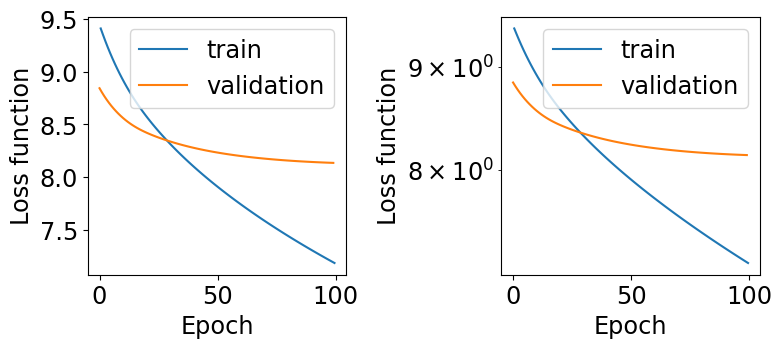

In [16]:
%time
# CBOW model training (optional)
#BEGIN_SOLUTION
class Dot(tf.keras.Layer):
    def call(self, x):
        dot_product = tf.math.multiply(x[0], x[1])
        dot_product = tf.math.reduce_sum(dot_product, axis=2)
        return dot_product


embedding_depth = 128
input_layer = tf.keras.layers.Input(shape=(window_size-1,), dtype=tf.int32)
embedding_layer = tf.keras.layers.Embedding(vocabulary_length, embedding_depth, name="embedding")
context_embedding = embedding_layer(input_layer)
vocabulary_embedding = embedding_layer(tf.range(vocabulary_length))
context_mean = tf.keras.layers.GlobalAveragePooling1D(keepdims=True)(context_embedding)
dot_product = Dot()([context_mean, vocabulary_embedding])
model = tf.keras.Model(inputs=input_layer, outputs=dot_product)
model.summary()
tf.keras.utils.plot_model(model, 'fig_png/ML_model.png', show_shapes=True)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
#END_SOLUTION

#Evaluate non trained model
model.evaluate(dataset_final.take(16))

#Training 
#BEGIN_SOLUTION
nEpochs = 100
initial_learning_rate = 2E-2
    
nStepsPerEpoch = 2200
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*10,
                decay_rate=0.95,
                staircase=False)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks = [early_stop_callback]
           
history = model.fit(dataset_final.skip(16).take(nStepsPerEpoch), 
                    validation_data=dataset_final.take(16),
                    epochs=nEpochs,
                    callbacks=callbacks, 
                    verbose=0)
    
model.evaluate(dataset_final.take(16))  
txt_fcn.dump_embedding(model, vocabulary)
plf.plotTrainHistory(history)

# Print model predictions
for batch in dataset_final.skip(16).take(5):
    print_item(batch, vocabulary)
    response = tf.math.argmax(model(batch[0]), axis=1)[0]
    print(colored("Response:", "blue"), vocabulary[response])
#END_SOLUTION
pass

In [17]:
# Embeding space exploration - words similar to "man"
#BEGIN_SOLUTION
#embedding_layer = tf.keras.layers.Embedding(vocabulary_length, embedding_depth, name="embedding")
embedding_layer = model.get_layer("embedding")
vocabulary_embedding = embedding_layer(tf.range(vocabulary_length))

word = "man"
word_index = np.where(vocabulary == word)[0][0]
word_embedding = vocabulary_embedding[word_index]

print(colored("Word embedding:", "blue"), word_embedding.shape)
print(colored("Vocabulary embedding:", "blue"), vocabulary_embedding.shape)
cosine_similarity = -tf.keras.losses.cosine_similarity(word_embedding, vocabulary_embedding, axis=-1)
euclidean_distance = tf.norm(word_embedding - vocabulary_embedding, axis=-1)

top_k = tf.math.top_k(cosine_similarity, k=5)
#top_k = tf.math.top_k(euclidean_distance, k=5)
top_k_indices = top_k.indices.numpy()
top_k_values = top_k.values.numpy() 
top_k_words = vocabulary[top_k_indices]
print(colored("Top 5 words similar to: ", "blue"), word)
for word, distance in zip(top_k_words, top_k_values):
    print(colored("\t"+word+"\t", "red"), distance)
 #END_SOLUTION
pass   

Word embedding: (128,)
Vocabulary embedding: (12563, 128)
Top 5 words similar to:  man
	man	 1.0000002
	doit	 0.7466506
	tail	 0.70508754
	lantern	 0.6959664
	bowl	 0.69375974


In [18]:
# Word arithmetics - words similar to "mother" + "father"
words = np.array(["father", "mother"])
#BEGIN_SOLUTION
words_indices = [np.where(vocabulary == x)[0][0] for x in words]
words_embedding = tf.gather(vocabulary_embedding, words_indices)
word_embedding =  words_embedding[0] + words_embedding[1]
euclidean_distance = tf.norm(word_embedding - vocabulary_embedding, axis=-1)
cosine_similarity =  tf.keras.losses.cosine_similarity(word_embedding, vocabulary_embedding, axis=-1)
top_k = tf.math.top_k(-euclidean_distance, k=5)
#top_k = tf.math.top_k(-cosine_similarity, k=5)
top_k_indices = top_k.indices.numpy()
top_k_values = top_k.values.numpy() 
top_k_words = vocabulary[top_k_indices]
print(colored("Top words similar to: ", "blue"), words[1]," + ", words[0])
for word, distance in zip(top_k_words, top_k_values):
    print(colored("\t"+word+"\t", "red"), distance)
#END_SOLUTION
pass    

Top words similar to:  mother  +  father
	father	 -61.984608
	son	 -78.47389
	mother	 -81.82756
	fathers	 -90.58149
	brother	 -91.30897


Odwzorowanie zanurzenia można zwizualizować z użyciem portalu [Embeding Projector](http://projector.tensorflow.org/?_gl=1*u2l7wh*_ga*MTg4NTM3NDUwOC4xNzA3OTg4NTU4*_ga_W0YLR4190T*MTcxNTI0MzQxOC44Ny4xLjE3MTUyNDQ5NzMuMC4wLjA.)
Na stronę trzeba załadować pliki `vectors.tsv` i `metadata.tsv` uzyskane z warstwy zanurzającej. 

In [19]:
def dump_embedding(model, vocabulary):
  import io
  out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
  out_m = io.open('metadata.tsv', 'w', encoding='utf-8')
  weights = model.get_layer('embedding').get_weights()[0]
  for index, word in enumerate(vocabulary):
    if index == 0:
      continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
  out_v.close()
  out_m.close()

dump_embedding(model, vocabulary)